# / Introduction

This notebook and others files are available in this [repository](https://github.com/DougTrajano/ds_covid-19_brazil) on GitHub.

## Objective

The objective of this analysis and modeling is trying to answer the question below.

> [Predict confirmed COVID-19 cases among suspected cases](https://www.kaggle.com/einsteindata4u/covid19/tasks?taskId=645)

## Data

The data used was provided by Albert Einstein Hospital from Brazil.

The target that we will trying to predict is `SARS-Cov-2 exam result`.

> If value is `1` the exam to SARS-Cov-2 was **positive**.

> If value is `0` the exam to SARS-Cov-2 was **negative**.

## Alerts

- This dataset doesn't has a metadata available, but I'll describe some variables based on their names.
- I don't have access to a doctor to provide health knowledge for this study. Then, the results from this analysis is invalid to use as real conclusions.

## / Imports, variables and configs setting.

In [1]:
import numpy as np
import pandas as pd
import json
import pandas_profiling as pdp
import missingno
from tqdm import tqdm
from IPython.core.display import HTML, Image
import os

# graphs
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [2]:
# Variables
pandas_profiling_executor = True # Change it for True if you want to update the latest report
pandas_profiling_file = "covid-19_br_einsteindata4u.html"
pandas_profiling_link = "https://github.com/DougTrajano/ds_covid-19_brazil/blob/master/covid-19_br_einsteindata4u.html"
target_col = "SARS-Cov-2 exam result"
file_path = "kaggle/input/covid19/dataset.xlsx"

## / Load file

In [3]:
print(file_path)
df = pd.read_excel(file_path)

print(df.shape)
df.head()

kaggle/input/covid19/dataset.xlsx
(5644, 111)


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
# / Data Transformation and Exploratory analysis

I decided to transform the data and explore it in the same time.

---
## / Pandas Profiling

Pandas Profile it's an amazing lib to get a quickly exploratory analysis.

In [4]:
if pandas_profiling_executor:
    profile = pdp.ProfileReport(df, title='COVID-19 - Hospital Albert Einstein BR', minimal=True)
    profile.to_file(output_file=pandas_profiling_file)
    pandas_profiling_link = pandas_profiling_file
    print("pandas_profiling_link changed to {}".format(pandas_profiling_file))
    
HTML('<a href="{href}" target="_blank">{link_name}</a>'.format(href=pandas_profiling_link,
                                                               link_name=pandas_profiling_file))


pandas_profiling_link changed to covid-19_br_einsteindata4u.html


---
## / Resume about pandas Profiling

We have a lot of features that has missing values,

To processind the dataset, we'll divide the columns in three categories:

- `cols_convert_to_binary`: Columns to be replaced by boolean values (0, 1).
- `cols_categorical`:  Columns to be replaced by numeric values in encoder.
- `cols_invalid`: Columns to be removed because it's ID or have no data available.

In [5]:
cols_convert_to_binary = ["SARS-Cov-2 exam result", "Respiratory Syncytial Virus", "Influenza A", "Influenza B",
                         "Parainfluenza 1", "CoronavirusNL63", "Rhinovirus/Enterovirus", "Coronavirus HKU1",
                         "Parainfluenza 3", "Chlamydophila pneumoniae", "Adenovirus", "Parainfluenza 4",
                         "Coronavirus229E", "CoronavirusOC43", "Inf A H1N1 2009", "Bordetella pertussis", 
                         "Metapneumovirus", "Parainfluenza 2", "Influenza B, rapid test", "Influenza A, rapid test",
                         "Strepto A", "Urine - Esterase", "Urine - Hemoglobin", "Urine - Bile pigments",
                         "Urine - Ketone Bodies", "Urine - Urobilinogen", "Urine - Protein", "Urine - Hyaline cylinders",
                         "Urine - Granular cylinders", "Urine - Yeasts", ]

cols_categorical = ["Urine - Aspect", "Urine - Crystals", "Urine - Leukocytes", "Urine - Color"]

cols_invalid = ["Patient ID", "Mycoplasma pneumoniae", "Fio2 (venous blood gas analysis)", "Urine - pH",
                "Urine - Nitrite", "Urine - Sugar", "Partial thromboplastin time\xa0(PTT)\xa0", "Vitamin B12"]

## / Check missing Values

Unfortunally, almost all columns have more than 90% of missing data.

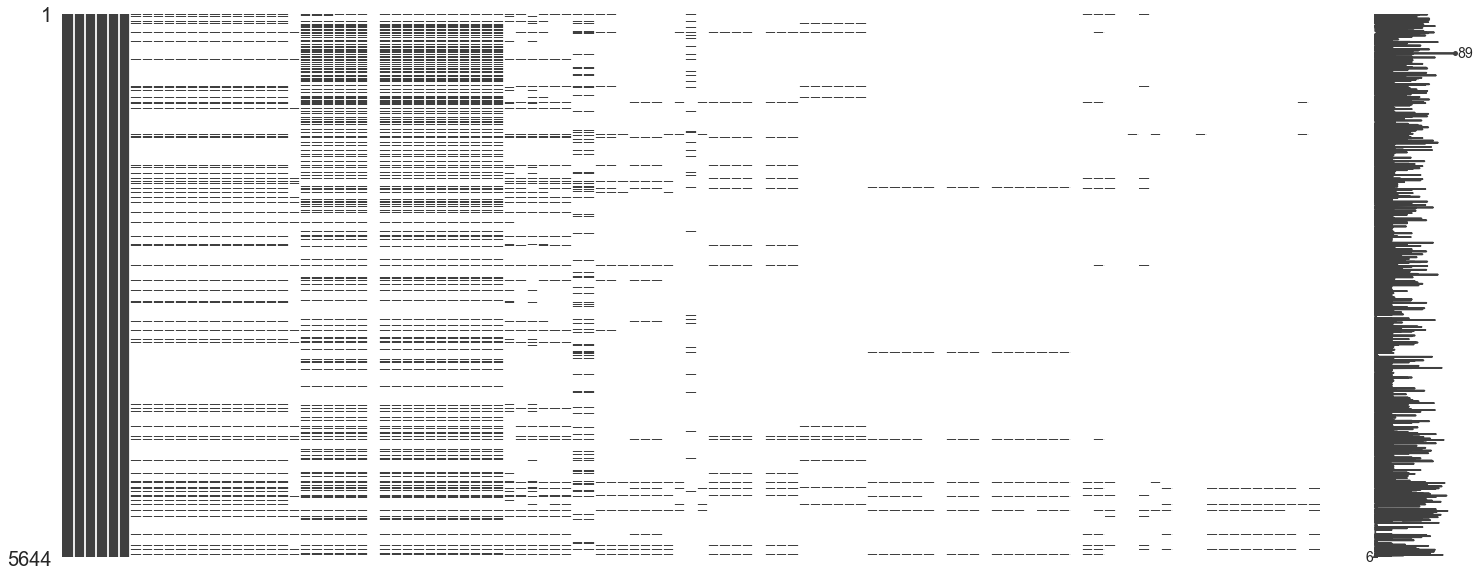

In [6]:
missingno.matrix(df);

I'll cut the dataset by `Hemoglobin` because when this feature is present, the missing values percentage it's smaller.

In [7]:
df = df[df["Hemoglobin"].notnull()]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(603, 111)


In [8]:
df_missing = []
for col in df.columns:
    missing = round((len(df[df[col].notnull()]) / len(df))*100, 2)
    missing = abs(missing - 100)
    df_missing.append({"column": col, "missing percentage": missing})
    if missing == 0:
        print("Column {col} has no missing values.".format(col=col))
    else:
        print("Column {col} has {missing}% of missing values.".format(col=col, missing=missing))

df_missing = pd.DataFrame(df_missing)

Column Patient ID has no missing values.
Column Patient age quantile has no missing values.
Column SARS-Cov-2 exam result has no missing values.
Column Patient addmited to regular ward (1=yes, 0=no) has no missing values.
Column Patient addmited to semi-intensive unit (1=yes, 0=no) has no missing values.
Column Patient addmited to intensive care unit (1=yes, 0=no) has no missing values.
Column Hematocrit has no missing values.
Column Hemoglobin has no missing values.
Column Platelets has 0.1700000000000017% of missing values.
Column Mean platelet volume  has 0.6599999999999966% of missing values.
Column Red blood Cells has 0.1700000000000017% of missing values.
Column Lymphocytes has 0.1700000000000017% of missing values.
Column Mean corpuscular hemoglobin concentration (MCHC) has 0.1700000000000017% of missing values.
Column Leukocytes has 0.1700000000000017% of missing values.
Column Basophils has 0.1700000000000017% of missing values.
Column Mean corpuscular hemoglobin (MCH) has 0.1

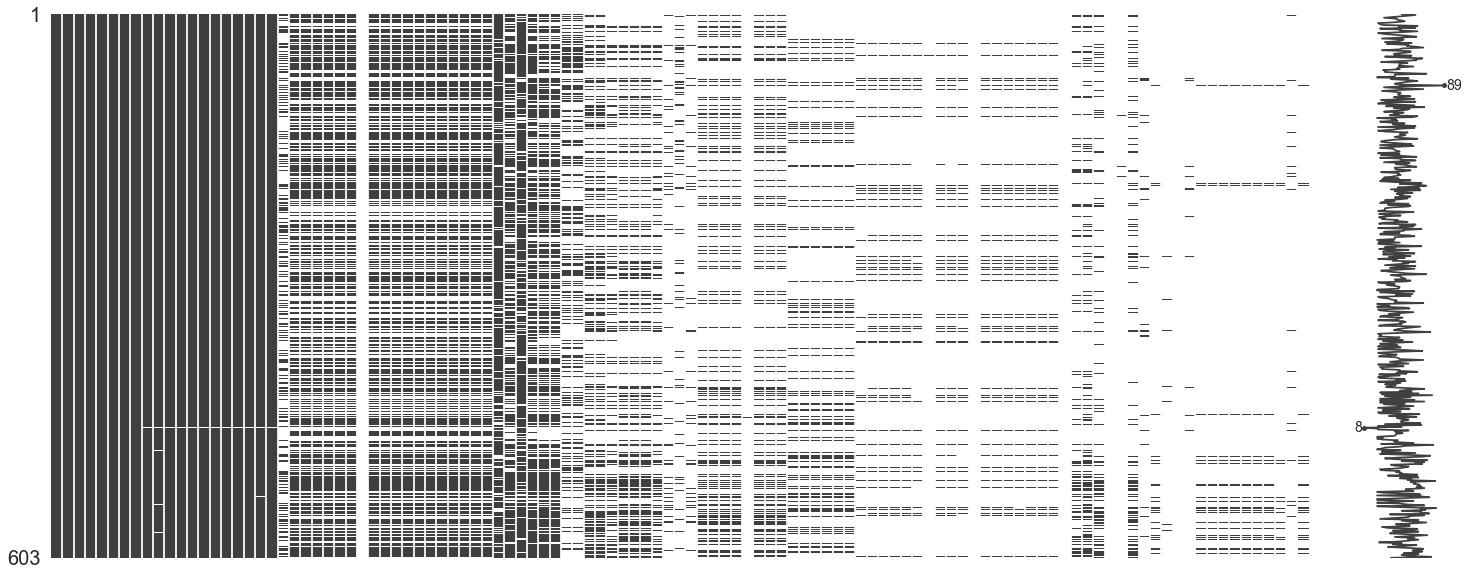

In [9]:
missingno.matrix(df);

It's better, but we lost a lot of data and actually we have missig values yet. We'll works on this later.

In [10]:
def _convert_to_binary(value):
    positive_lst = [1, "positive", "detected", "present", "normal"]
    negative_lst = [0, "negative", "not_detected", "absent", "not_done"]
    if value in positive_lst:
        return 1
    elif value in negative_lst:
        return 0
    else:
        return value
    
    
def processing(dataset, cols_invalid=None, cols_categorical=None, cols_convert_to_binary=None):
    """
    docstring
    """
    temp = dataset.to_dict(orient="records")    
    df_processed = []
    
    # processing each record
    with tqdm(total=len(temp)) as pbar:
        for values in temp:
            if isinstance(cols_convert_to_binary, list):
                for col in cols_convert_to_binary:
                    values[col] = _convert_to_binary(values[col])

            if isinstance(cols_invalid, list):    
                for col in cols_invalid:
                    del values[col]

            if isinstance(cols_categorical, list):
                for col in cols_categorical:
                    values = _encoder(values)
        
            # add processed record
            df_processed.append(values)
            pbar.update(1)
        
    df_processed = pd.DataFrame(df_processed)
    return df_processed


def _encoder(value):
    filename = "cat_features_encoding.json"
    with open(filename, 'r') as filename:
        encoding = json.load(filename)
        
    for col in encoding.keys():        
        for i in encoding[col]:
            if value[col] == i:
                value[col] = encoding[col][i]             
        
    return value


def create_encoder(dataset, cat_features):
    """
    This function can create a Label Encoder for categorical features.
    
    A json file called "cat_features_encoding.json" will be saved on folder's script. This file can be used on _encoder function.
    Input
    - dataset (DataFrame, required): The DataFrame loaded from listings.csv.
    - cat_features (list, required): The categorical features list that you want to convert in numeric values.
    Output
    - encoding (dict): A dictionary with the encoder created. The same content of json file.
    """
    encoding = {}
    filename = "cat_features_encoding.json"
    for col in cat_features:
        temp = {}
        n_values = dataset[col].unique()
        i = 0
        for n in n_values:
            temp[str(n)] = i
            i += 1
        encoding[col] = temp
    
    # save json file encoder
    with open(filename, 'w') as filename:
        json.dump(encoding, filename)
        
    return encoding

---
## / LabelEncoder for categorical features

In [11]:
for col in cols_categorical:
    print(col, len(df[col].unique()))
    print(df[col].unique())
    print()

Urine - Aspect 5
[nan 'clear' 'altered_coloring' 'cloudy' 'lightly_cloudy']

Urine - Crystals 5
[nan 'Ausentes' 'Urato Amorfo --+' 'Oxalato de Cálcio -++'
 'Urato Amorfo +++']

Urine - Leukocytes 28
[nan '38000' '32000' '22000' '<1000' '3000' '16000' '7000' '5300' '4000'
 '1000' '5000' '6000' '2500' '124000' '8000' '29000' '2000' '624000'
 '40000' '3310000' '229000' '19000' '28000' '10000' '4600' '77000' '43000']

Urine - Color 5
[nan 'light_yellow' 'orange' 'yellow' 'citrus_yellow']



In [12]:
create_encoder(df, cols_categorical)

{'Urine - Aspect': {'nan': 0,
  'clear': 1,
  'altered_coloring': 2,
  'cloudy': 3,
  'lightly_cloudy': 4},
 'Urine - Crystals': {'nan': 0,
  'Ausentes': 1,
  'Urato Amorfo --+': 2,
  'Oxalato de Cálcio -++': 3,
  'Urato Amorfo +++': 4},
 'Urine - Leukocytes': {'nan': 0,
  '38000': 1,
  '32000': 2,
  '22000': 3,
  '<1000': 4,
  '3000': 5,
  '16000': 6,
  '7000': 7,
  '5300': 8,
  '4000': 9,
  '1000': 10,
  '5000': 11,
  '6000': 12,
  '2500': 13,
  '124000': 14,
  '8000': 15,
  '29000': 16,
  '2000': 17,
  '624000': 18,
  '40000': 19,
  '3310000': 20,
  '229000': 21,
  '19000': 22,
  '28000': 23,
  '10000': 24,
  '4600': 25,
  '77000': 26,
  '43000': 27},
 'Urine - Color': {'nan': 0,
  'light_yellow': 1,
  'orange': 2,
  'yellow': 3,
  'citrus_yellow': 4}}

In [13]:
df_processed = processing(df, cols_invalid=cols_invalid, cols_categorical=cols_categorical,
                         cols_convert_to_binary=cols_convert_to_binary)

print(df_processed.shape)
df_processed.head()

100%|███████████████████████████████████████████████████████████████████████████████| 603/603 [00:00<00:00, 758.20it/s]

(603, 103)


,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.730393,NaN
2,9,0,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,0,0,0,0,0.991838,0.792188,0.072992,-0.550290,0.542763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,0,0,0,0,0.190738,-0.147652,-0.668155,1.020415,-0.127191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Columns: 103 entries, Patient age quantile to ctO2 (arterial blood gas analysis)
dtypes: float64(98), int64(5)
memory usage: 485.4 KB


---
## / Relevant features

Using correlation we can filter relevant features on this dataset. The correlation will be applied in target_col `SARS-Cov-2 exam result`.

In [15]:
# Correlation features
cor = df_processed.corr()
cor_target = abs(cor[target_col])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05].sort_values(ascending=False)

df_cols_stats = pd.DataFrame(relevant_features[1:])
df_cols_stats.reset_index(inplace=True)
df_cols_stats.columns = ["column", "correlation with exam result"]
df_cols_stats = pd.merge(df_cols_stats, df_missing, on="column")
df_cols_stats.head(20)

,column,correlation with exam result,missing percentage
0,Urine - Leukocytes,0.408275,91.04
1,pCO2 (arterial blood gas analysis),0.323977,95.52
2,pH (arterial blood gas analysis),0.314820,95.52
3,pO2 (arterial blood gas analysis),0.312537,95.52
4,Arteiral Fio2,0.310583,96.68
5,"Patient addmited to regular ward (1=yes, 0=no)",0.310454,0.00
6,Ionized calcium,0.305113,91.71
7,Leukocytes,0.288508,0.17
8,Platelets,0.282268,0.17
9,ctO2 (arterial blood gas analysis),0.267457,95.52


Almost all of relevant features has a high number of missing values.

I'll trying to get a mix of correlation and missing percentage that I think that it's good enough.

In [16]:
cols_pairplot_filter = df_cols_stats[df_cols_stats["missing percentage"] < 90]["column"].tolist()
cols_pairplot_filter.append(target_col) # add target_col to the columns

df_cols_stats[df_cols_stats["missing percentage"] < 90]

,column,correlation with exam result,missing percentage
5,"Patient addmited to regular ward (1=yes, 0=no)",0.310454,0.00
7,Leukocytes,0.288508,0.17
8,Platelets,0.282268,0.17
12,Rhinovirus/Enterovirus,0.246083,39.30
14,Monocytes,0.197333,0.33
15,Eosinophils,0.192609,0.17
17,Segmented,0.186514,83.91
19,Aspartate transaminase,0.153164,62.69
20,Patient age quantile,0.152746,0.00
23,Indirect Bilirubin,0.143971,69.98


In [17]:
df_processed[cols_pairplot_filter].groupby(by=target_col).count().transpose()

SARS-Cov-2 exam result,0,1
"Patient addmited to regular ward (1=yes, 0=no)",520,83
Leukocytes,519,83
Platelets,519,83
Rhinovirus/Enterovirus,314,52
Monocytes,518,83
Eosinophils,519,83
Segmented,88,9
Aspartate transaminase,185,40
Patient age quantile,520,83
Indirect Bilirubin,141,40


---
## / Pairplots

The pairplot created by Seaborn it's very useful to understand the behavior of a specific column between others columns of the dataset.

We'll check how the **relevant features** are distributed considering `SARS-Cov-2 exam result`.

Pairplot - 1
Wall time: 1min 41s


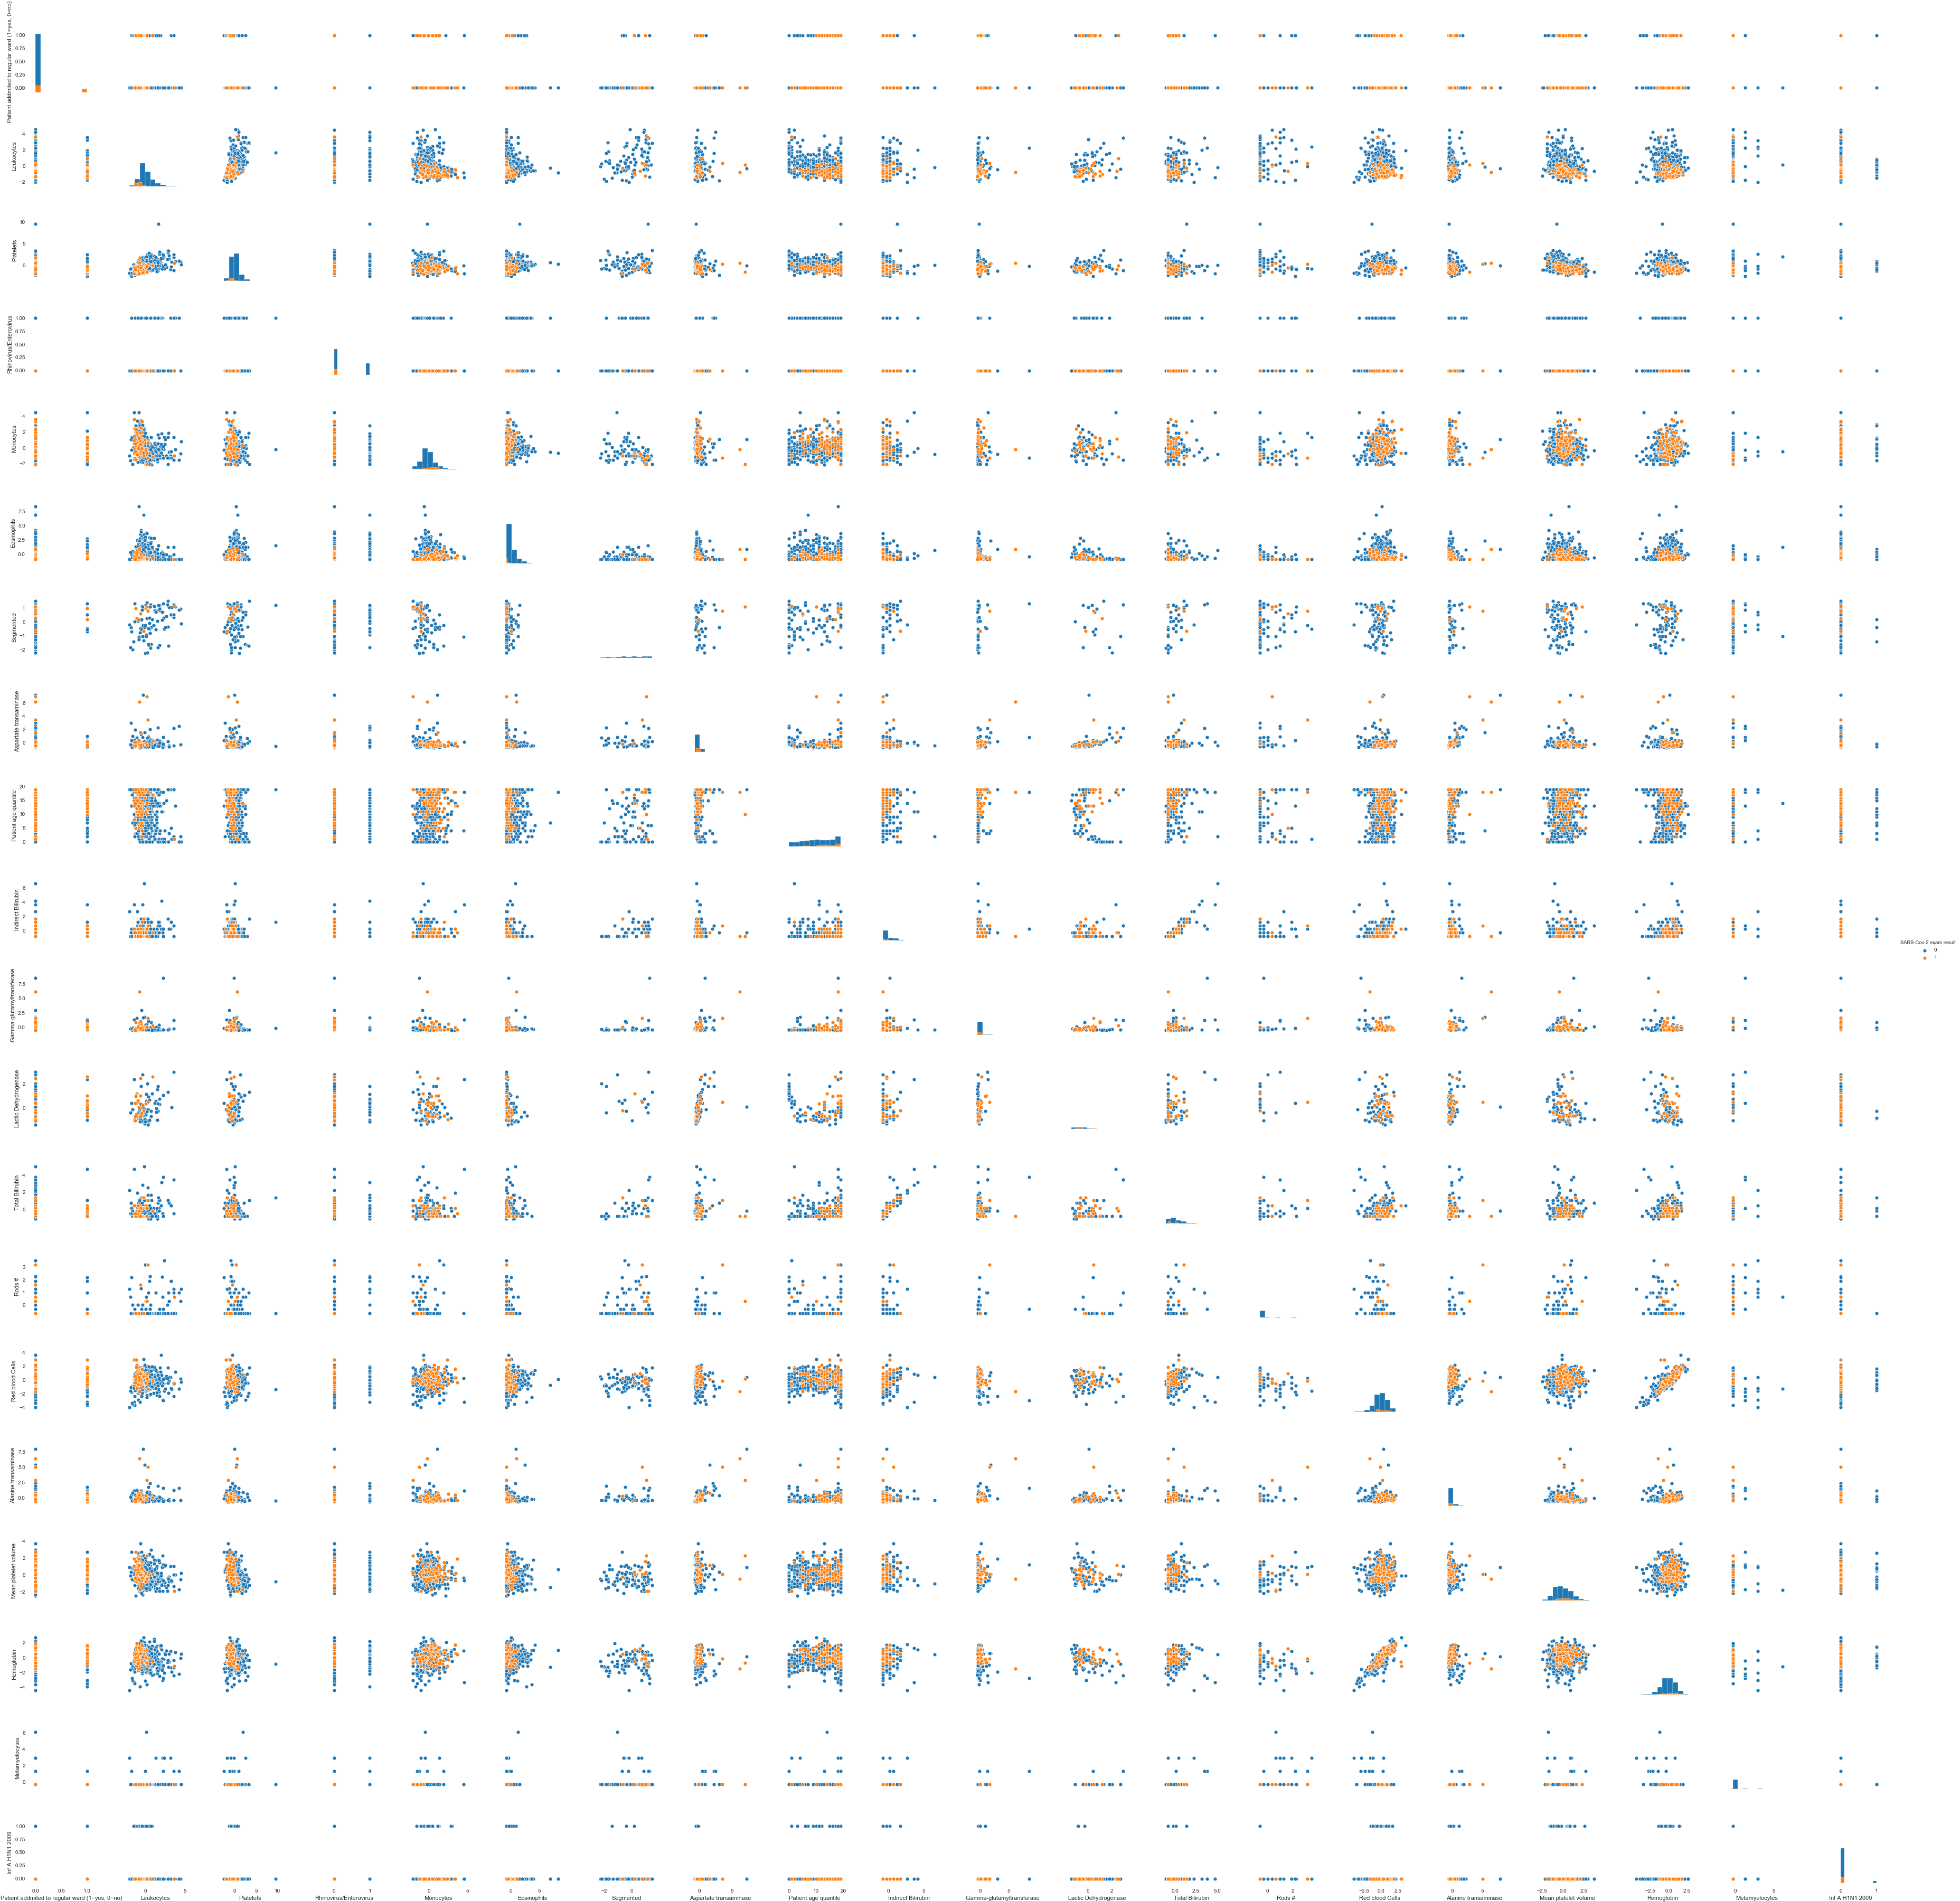

<Figure size 3712.75x3600 with 0 Axes>

In [18]:
%%time
pairplot_file = "pairplot_1.png"
temp = cols_pairplot_filter[:20]
if target_col not in temp:
    temp.append(target_col)

print("Pairplot - 1")
sns.pairplot(df_processed[temp], hue=target_col, diag_kind="hist", dropna=True)
plt.savefig(pairplot_file)

plt.clf() # Clean parirplot figure from sns

Image(filename=pairplot_file) # Show pairplot as image

In [19]:
# Download image
HTML('<a href="{href}" target="_blank">Download image (1)</a>'.format(href=pairplot_file))

Pairplot - 2
Wall time: 1min 34s


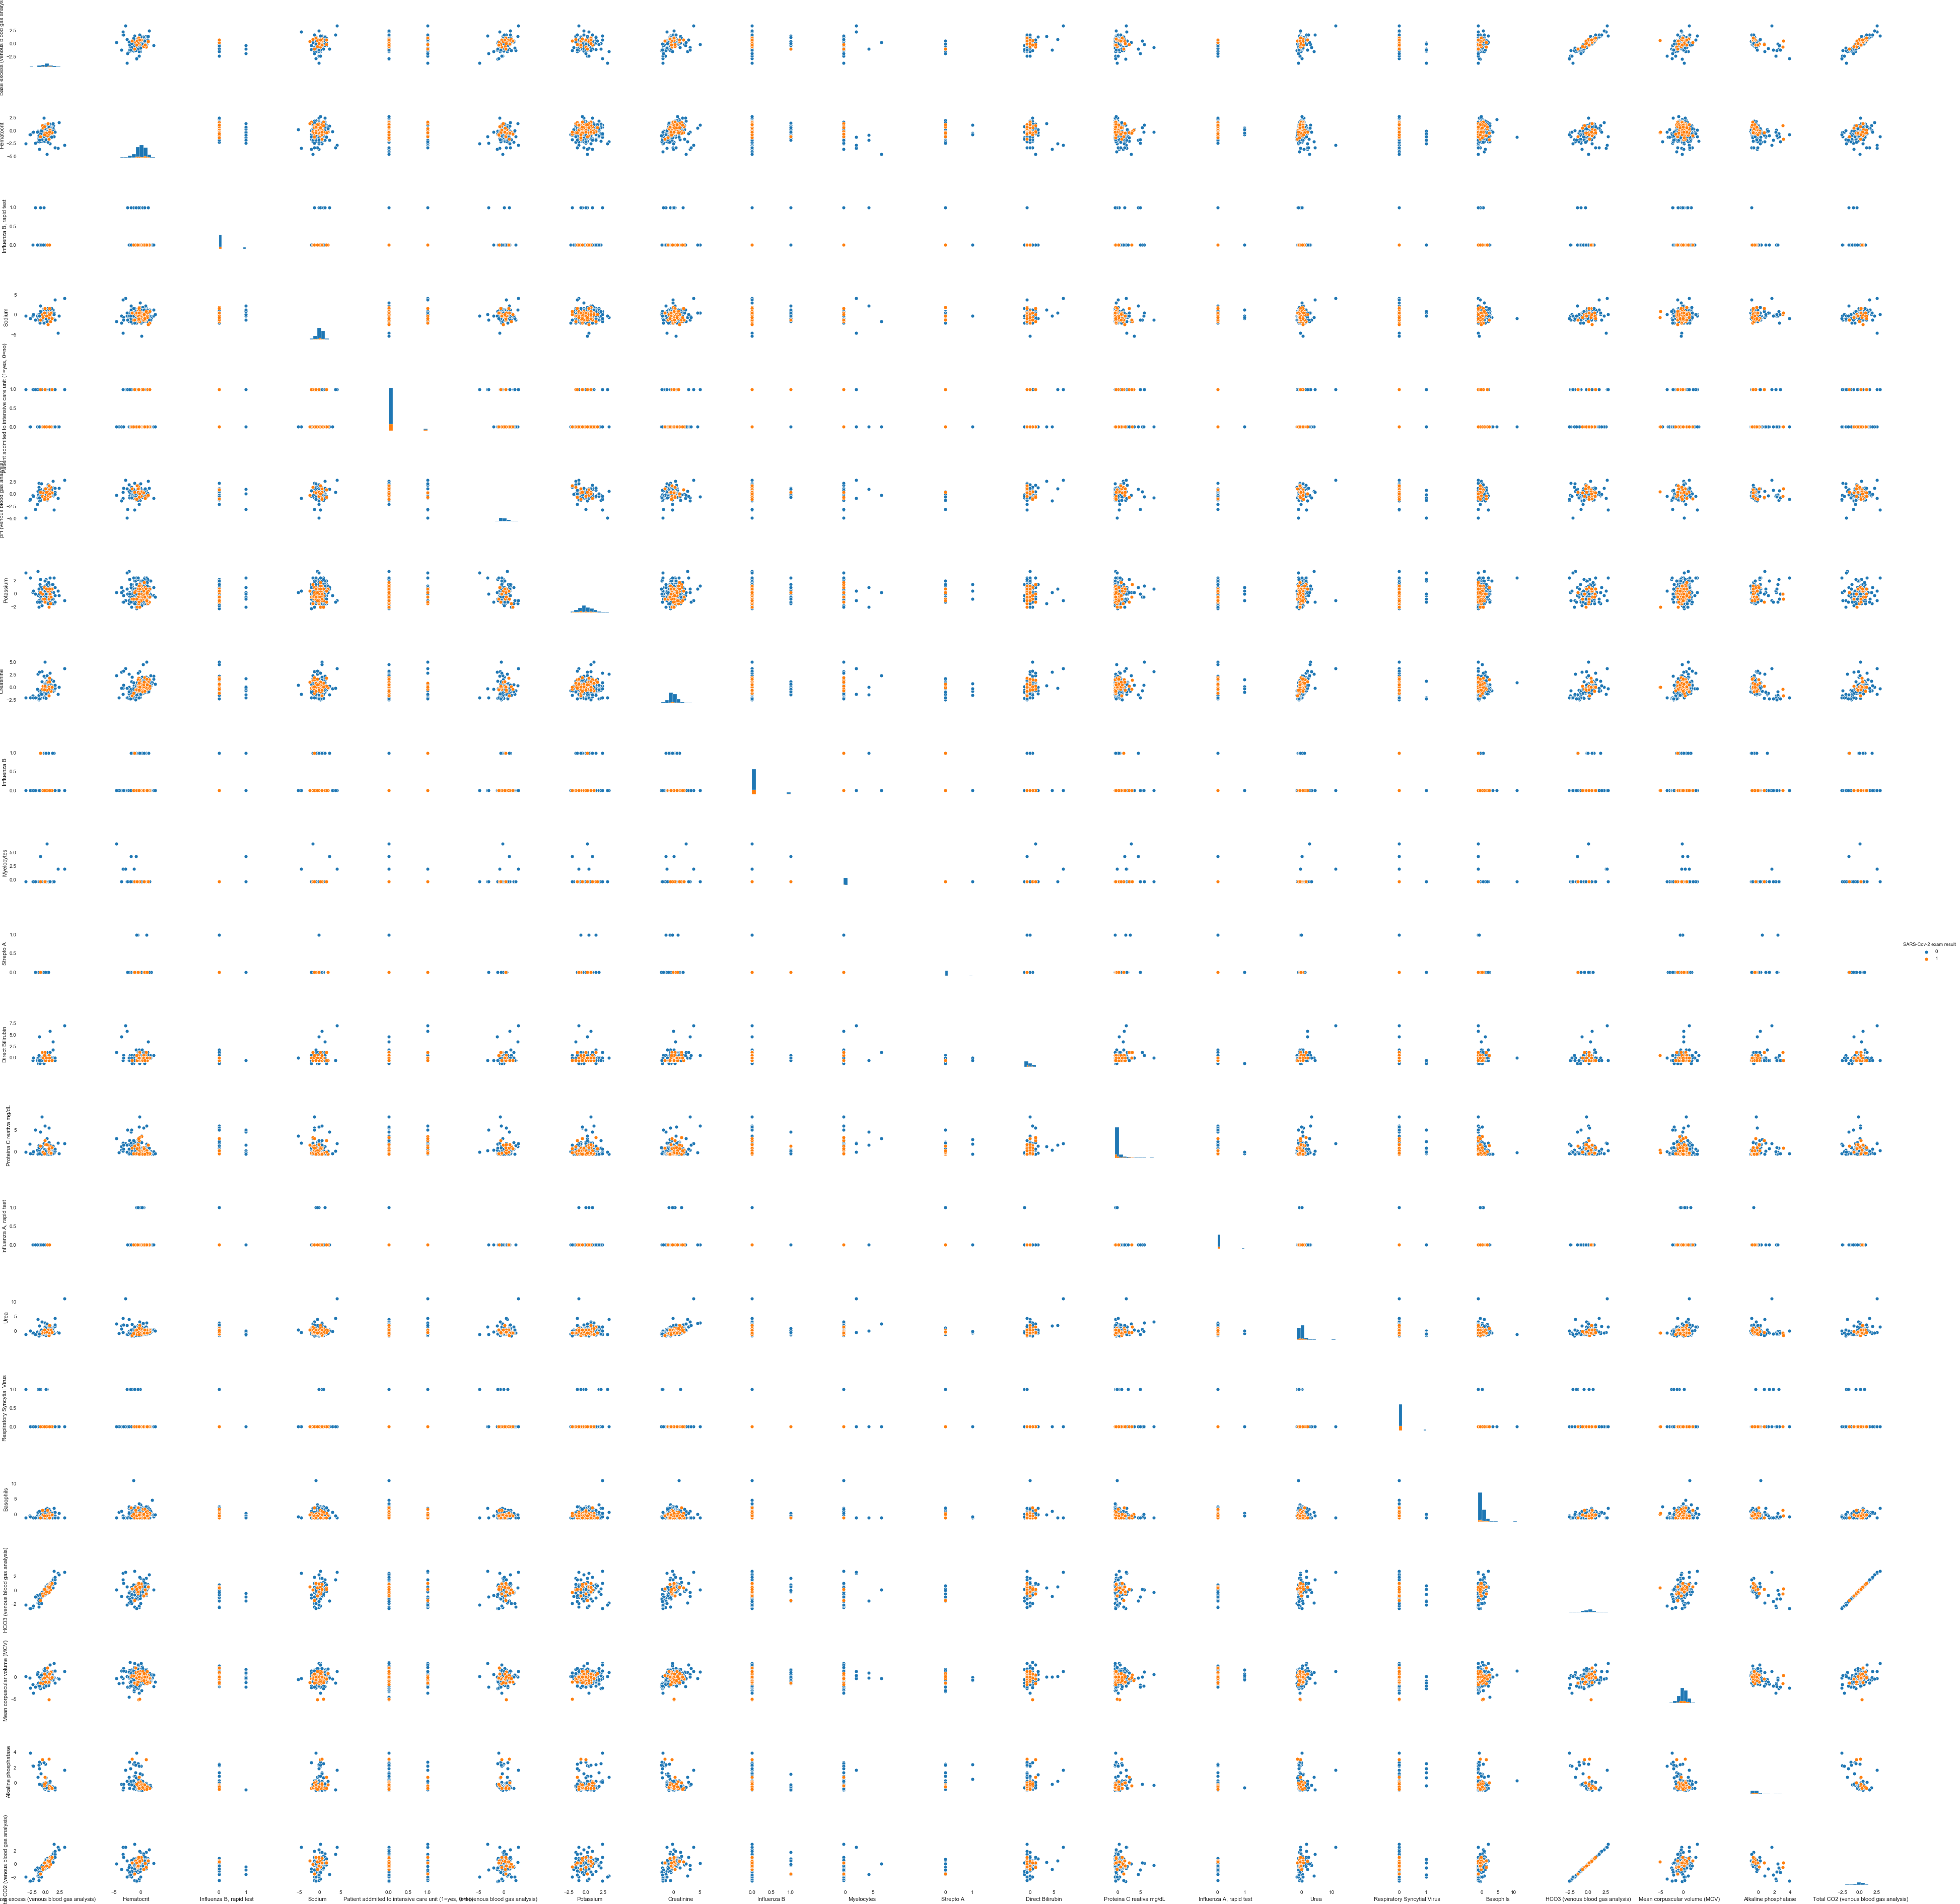

<Figure size 3892.75x3780 with 0 Axes>

In [20]:
%%time
pairplot_file = "pairplot_2.png"
temp = cols_pairplot_filter[20:]
if target_col not in temp:
    temp.append(target_col)
    
print("Pairplot - 2")
sns.pairplot(df_processed[temp], hue=target_col, diag_kind="hist", dropna=True)
plt.savefig(pairplot_file)

plt.clf() # Clean parirplot figure from sns

Image(filename=pairplot_file) # Show pairplot as image

In [21]:
# Download image
HTML('<a href="{href}" target="_blank">Download image (2)</a>'.format(href=pairplot_file))

We can see that these selected features has a good distribution between values of the target_col `SARS-Cov-2 exam result`.

I don't know if this distribution make sense in the health sector, but seeing only in the data for this small dataset, we can see that.

---

# / Modeling

## / Filling missing values

Filling **missing values** in this dataset will be a challenge because the percentage of missing values it's very high.

We'll get the relevant features that has more than 10% of the values, for these columns we'll use KNNImputer to complete missing values.

In [22]:
df_processed[cols_pairplot_filter].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 42 columns):
Patient addmited to regular ward (1=yes, 0=no)           603 non-null int64
Leukocytes                                               602 non-null float64
Platelets                                                602 non-null float64
Rhinovirus/Enterovirus                                   366 non-null float64
Monocytes                                                601 non-null float64
Eosinophils                                              602 non-null float64
Segmented                                                97 non-null float64
Aspartate transaminase                                   225 non-null float64
Patient age quantile                                     603 non-null int64
Indirect Bilirubin                                       181 non-null float64
Gamma-glutamyltransferase                                152 non-null float64
Lactic Dehydrogenase                      

In [23]:
X = df_processed[cols_pairplot_filter]

imputer = KNNImputer(n_neighbors=4)
X = imputer.fit_transform(X.values)

X = pd.DataFrame(X, columns=cols_pairplot_filter)
X.head()

,"Patient addmited to regular ward (1=yes, 0=no)",Leukocytes,Platelets,Rhinovirus/Enterovirus,Monocytes,Eosinophils,Segmented,Aspartate transaminase,Patient age quantile,Indirect Bilirubin,...,Proteina C reativa mg/dL,"Influenza A, rapid test",Urea,Respiratory Syncytial Virus,Basophils,HCO3 (venous blood gas analysis),Mean corpuscular volume (MCV),Alkaline phosphatase,Total CO2 (venous blood gas analysis),SARS-Cov-2 exam result
0,0.0,-0.094610,-0.517413,1.0,0.357547,1.482158,-0.540209,0.244242,17.0,-0.032465,...,-0.147895,0.0,1.198059,0.0,-0.223767,0.068651,0.166192,-0.547925,0.065704,0.0
1,0.0,0.364550,1.429667,0.0,0.068652,1.018625,-1.481803,-0.162200,1.0,-0.401749,...,-0.286986,0.0,-0.067309,0.0,-0.223767,0.036345,-1.336024,1.187841,0.104088,0.0
2,0.0,-0.884923,-0.429480,0.0,1.276759,-0.666950,-0.566733,-0.549287,9.0,-0.155559,...,-0.355041,1.0,-0.811643,0.0,0.081693,0.270566,1.668409,-0.635475,0.280653,0.0
3,0.0,-0.211488,0.072992,1.0,-0.220244,-0.709090,0.175932,-0.171877,11.0,1.075389,...,-0.487674,0.0,-0.123134,0.0,-0.834685,0.141341,0.606842,-0.304309,0.165502,0.0
4,0.0,-1.132592,-0.668155,0.0,2.012129,-0.709090,-0.778923,-0.413807,9.0,-0.032465,...,-0.385343,0.0,-1.332677,0.0,0.387152,0.270566,0.566783,-0.719218,0.280653,0.0


## / Split in X and Y

In this section we'll split the features `X` and the answer `Y`.

In [24]:
y = X[target_col].values
X.drop(columns=[target_col], inplace=True)

## / Unbalanced classes

Houston. We have a problem! o/

We have **unbalanced classes**. See below the numbers of each classes.

Class 0: [520] - (86.24%)
Class 1: [83] - (13.76%)


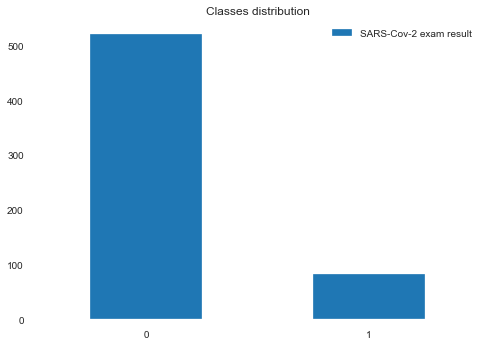

In [25]:
temp = pd.DataFrame(df_processed[target_col].value_counts())

for each in range(len(temp)):
    percentage = temp.values[each]/sum(temp.values)
    percentage = round(percentage[0]*100, 2)
    print("Class {ix}: {qty} - ({percentage}%)".format(ix=temp.index[each], qty=temp.values[each], percentage=percentage))

df_processed["SARS-Cov-2 exam result"].value_counts().plot(kind="bar", title="Classes distribution", legend=True, rot=1);

## / Class weight

To solve the **unbalanced classes** we will compute class weight and use it on the algorithms.

In [26]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

print(class_weights)

{0: 0.5798076923076924, 1: 3.6325301204819276}


## / Split in train and test

Here we'll split the datasets (`X`, `Y`) again, but now, in **train** and **test**.

In [27]:
# Split the dataset in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("train size:", len(X_train))
print("test size:", len(X_test))

train size: 404
test size: 199


## / Random Forest

In [28]:
%%time
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0, 
                             min_samples_leaf=5, min_samples_split=15,
                             class_weight=class_weights, n_jobs=-1)

clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=5)
y_pred = clf.predict(X_test)

print("Accuracy (cross-validation): %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print()
print(classification_report(y_test, y_pred, digits=4))

Accuracy (cross-validation): 0.91 (+/- 0.03)

              precision    recall  f1-score   support

         0.0     0.9270    0.9649    0.9456       171
         1.0     0.7143    0.5357    0.6122        28

    accuracy                         0.9045       199
   macro avg     0.8206    0.7503    0.7789       199
weighted avg     0.8970    0.9045    0.8987       199

Wall time: 5.78 s


## / GridSearchCV

In [29]:
%%time

parameters = {'n_estimators':[25, 50, 100, 200, 300],
             "min_samples_leaf": [5, 10, 15, 20],
             "min_samples_split": [5, 10, 15, 20],
             "criterion": ["gini", "entropy"]}

model = RandomForestClassifier(random_state=0, class_weight=class_weights, n_jobs=-1)
clf = GridSearchCV(model, parameters, cv=5, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)
clf = clf.best_estimator_
preds = clf.predict(X_test)
print(classification_report(y_test, preds, digits=4))
clf

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.7min finished


              precision    recall  f1-score   support

         0.0     0.9270    0.9649    0.9456       171
         1.0     0.7143    0.5357    0.6122        28

    accuracy                         0.9045       199
   macro avg     0.8206    0.7503    0.7789       199
weighted avg     0.8970    0.9045    0.8987       199

Wall time: 1min 44s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5798076923076924,
                                     1: 3.6325301204819276},
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# / Conclusions

We have few samples for **positive cases** in `SARS-Cov-2 exam result` feature and for this small dataset of positive cases, we have a lot of missing values that doesn't provide any trust that this model will works in the real world. We filled a lot of missing values in the dataset and that it's not good.

In the meantime, I think that this study can help advance knowledge about **COVID-19**.

I hope that more data about clinical spectrum can be provided. In the future, we can provide better models or understand the impacts of the coronavírus on our bodies.